In [1]:
import rasterio
from rasterio.plot import show
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from skimage import io
import torchvision.transforms as T
from torchmetrics import F1Score
import sys
from sklearn.manifold import TSNE
import pandas as pd

sys.path.append('../Models/Networks')

from U_Net import *

C:\Users\mdomi\miniconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = 'cuda'

In [3]:
model = torch.load('../Models/Experiments/U_Net_SourceOnlyCIVwithImAug.pt')
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [10]:
countries = ['IvoryCoast', 'Tanzania']

num_imgs = 100

FEs_CIV = []

conversion = T.ToTensor()

for country in countries:

    img_folder = '../Data/Planet/'+country+'/'
    
    for idx in range(num_imgs):
        img = io.imread(fname = img_folder + '/Cropped' + country + 'StudyArea_{:05d}'.format(idx) + '.tif').astype(np.float32)
        img = img/np.max(img)
        img = conversion(img).float()[None, :, :, :]
        
        F = model.return_FE(img.to(device), 2)
        
        FEs_CIV.append(F.flatten().cpu().detach().numpy())
        
FE_df = pd.DataFrame(FEs_CIV)

In [11]:
FE_df = pd.DataFrame(FEs_CIV)

comps = 2

tsne = TSNE(comps, perplexity = 100, n_iter =  500)

FE_tsne = tsne.fit_transform(FE_df)

C:\Users\mdomi\miniconda3\envs\pytorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mdomi\miniconda3\envs\pytorch\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

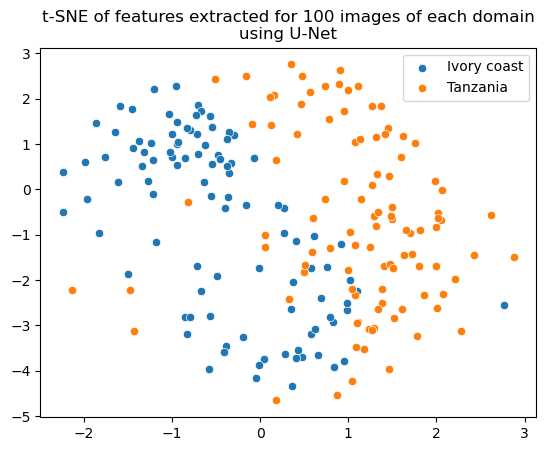

In [14]:
sns.scatterplot(x = FE_tsne[:num_imgs, 0], y = FE_tsne[:num_imgs, 1], label = 'Ivory coast')
sns.scatterplot(x = FE_tsne[num_imgs:, 0], y = FE_tsne[num_imgs:, 1], label = 'Tanzania')

ax = plt.gca()

ax.set_title('t-SNE of features extracted for 100 images of each domain\nusing U-Net')

fig = plt.gcf()

fig.savefig('../imgs/t_SNE_Example_U_NET_FeaturesExtracted.png')